# MLPClassifier Migraine Prediction

This notebook demonstrates migraine prediction using a Multi-Layer Perceptron (MLP) neural network, leveraging the modular data processing and feature engineering functions from `prediction/data_processing.py`.

In [25]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# 1. Import Libraries and Data Processing Functions
from prediction.data_processing import merge_migraine_and_weather_data, process_combined_data
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 2. Merge and Process Data
We merge the migraine and weather data, then process the combined data to engineer features and prepare it for modeling.

In [26]:
# Merge migraine and weather data (regenerate combined_data.csv)
merge_migraine_and_weather_data()

# Load and process combined data
combined_data = process_combined_data()

## 3. Prepare Features and Target for Binary Classification
We prepare the features and target variable for predicting whether a migraine occurred (binary classification).

In [27]:
features = combined_data.dropna(axis=1)  # Drop columns with any NaN values
features = features.drop(columns=[
    'Date', 'date',
    'Medication',
    'Dosage',
    'Triggers',
    'Notes',
    'Location',
    'Timezone',
    'Pain Level',
    'Pain_Level_Binary',
    'Pain_Level_Log',
    'Longitude',
    'Latitude',
    'Time',
    'Latitude_x', 'Longitude_x', 'Latitude_y', 'Longitude_y',
],
errors='ignore'
)
target_binary = combined_data['Pain_Level_Binary']

## 4. Train and Evaluate MLPClassifier for Binary Classification
We split the data, train an MLPClassifier to predict migraine occurrence, and evaluate its performance.

/Users/Aresh/Desktop/Projects/Migraine Navigator/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


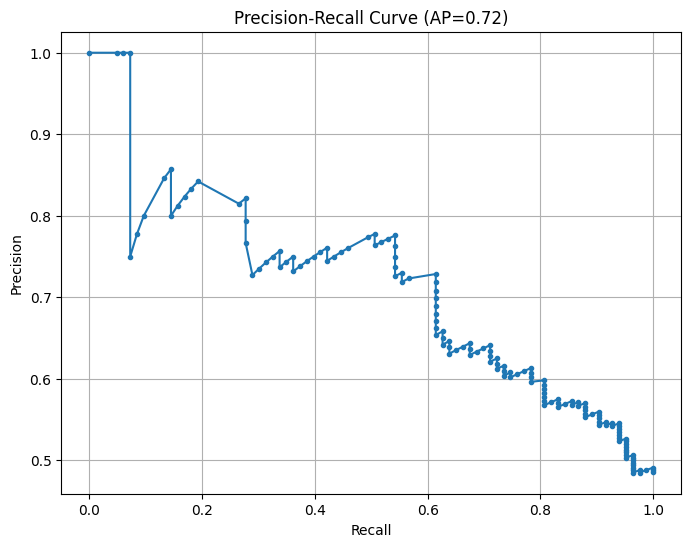

Binary Classification Accuracy: 0.68
Binary Classification F1 Score: 0.65


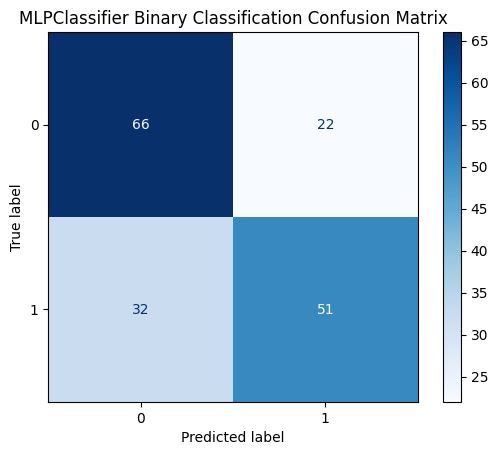

In [28]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier

# 1. Split data
X_train, X_test, y_train, y_test = train_test_split(
    features, target_binary, test_size=0.2, random_state=42
)

# 2. Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Resample training data (SMOTE only, no undersampling)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# 4. Train MLPClassifier (match ensemble_model.ipynb)
mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42)
mlp.fit(X_train_res, y_train_res)

# 5. Predict probabilities
y_pred_proba = mlp.predict_proba(X_test_scaled)[:, 1]

# 6. Precision-recall curve (for reference, not for threshold selection)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
ap = average_precision_score(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AP={ap:.2f})')
plt.grid(True)
plt.show()

# 7. Final predictions using fixed threshold 0.5 (to match ensemble_model.ipynb)
y_pred = (y_pred_proba > 0.5).astype(int)

# 8. Evaluation
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Binary Classification Accuracy: {accuracy:.2f}")
print(f"Binary Classification F1 Score: {f1:.2f}")

# 9. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("MLPClassifier Binary Classification Confusion Matrix")
plt.show()